# LGTFA25 Unit 3 Day 3 Exercises

In [2]:
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

In [58]:
# Do not modify anything in this cell.
'''
Run this cell to generate a small ensemble of 5 configurations to use in today's exercises.
'''

Ul = []
Ls = 8
Lt = 8
beta = 5.9
L = [Ls,Ls,Ls,Lt]
grid = g.grid(L, g.single)
grid_eo = g.grid(L, g.single, g.redblack)

rng = g.random("test", "vectorized_ranlux24_24_64") #change this?
U = g.qcd.gauge.unit(grid)
Nd = len(U)

# red/black mask
mask_rb = g.complex(grid_eo)
mask_rb[:] = 1
# full mask
mask = g.complex(grid)

# simple plaquette action
def staple(U, mu):
    st = g.lattice(U[0])
    st[:] = 0
    Nd = len(U)
    for nu in range(Nd):
        if mu != nu:
            st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
    return st

g.default.push_verbose("su2_heat_bath", False)
markov = g.algorithms.markov.su2_heat_bath(rng)
U = g.qcd.gauge.unit(grid)
plaquette_heatbath = []
for it in range(101):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_heatbath.append(plaq)
    if it % 50 == 0 and it != 0:
        g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
        Uc = g.copy(U)
        Ul.append(Uc)
    for cb in [g.even, g.odd]:
        mask[:] = 0
        mask_rb.checkerboard(cb)
        g.set_checkerboard(mask, mask_rb)
        
        for mu in range(Nd):
                    st = g.eval(beta * staple(U, mu))
                    markov(U[mu], st, mask)

GPT :   55829.459893 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 4.69685e-05 s
GPT :   55839.590499 s : SU(2)-subgroup heatbath 50 has P = 0.5794221030341254
GPT :   55850.167609 s : SU(2)-subgroup heatbath 100 has P = 0.5832406149970161
GPT :   55860.030252 s : SU(2)-subgroup heatbath 150 has P = 0.5825011995103624
GPT :   55872.806423 s : SU(2)-subgroup heatbath 200 has P = 0.581952624850803
GPT :   55884.096895 s : SU(2)-subgroup heatbath 250 has P = 0.5810537868075901


## 1. Domain wall fermions and residual mass
In this part we will develop a method to calculate the residual mass using the axial Ward-Takahashi identity, and then show the decaying exponential behavior
of the residual mass for increasing Ls. 

### Exercise 1.1 [Analytic]: Vector current conservation

The conserved five dimensional current is given by 
$$
j_{\mu}^a(x,s) = \frac{1}{2}\left(\overline{\psi}_{x,s}(1 + \gamma_{\mu}) U_{x,\mu} \lambda^a\psi_{x + \hat{\mu},s} - \overline{\psi}_{x + \hat{\mu},s}(1-\gamma_{\mu})U^{\dagger}_{x,\mu}\lambda^a\psi_{x,s} \right)
$$

with the fifth component being defined by 
$$
    j^a_5(x,s) = 
    \begin{cases}
        \overline{\psi}_{x,s}P_R\lambda^a\psi_{x,s+1} - \overline{\psi}_{x,s+1}P_L\lambda^a\psi_{x,s}, & 1 \le s < 2N \\
        \overline{\psi}_{x,2N}P_R\lambda^a\psi_{x,1} - \overline{\psi}_{x,1}P_L\lambda^a\psi_{x,2N}, & s = 2N
    \end{cases}
$$

Show that the five dimensional current satisfies the following continuity equation
$$
    \sum_{\mu}\Delta_{\mu}j_{\mu}^a = 
    \begin{cases}
        -j_5^a(x,1) - mj_5^a(x,2N), & s = 1 \\
        -\Delta_5 j_5^a(x,s), & 1 < s < 2N - 1 \\
        j_5^a(x,2N-1) + mj^a_5(x,2N), & s = 2N
    \end{cases}
$$

where 
$$
    \Delta_{\mu} f(x,s) = f(x,s) - f(x-\hat{\mu},s) $$
    $$\Delta_5 f(x,s) = f(x,s) - f(x,s-1).$$
and $\lambda^a$ is a generator for the flavor symmetry group. 

### Background: Ward-Takahashi Identities
Ward-Takahashi identites express the quantum analog of classical current conservation associated with a continuous symmetry, written in terms of correlation functions. Generally, if we have some transformation of fermion fields
$$
\psi \rightarrow \psi' = \psi + \delta\psi $$
$$\overline{\psi} \rightarrow \overline{\psi}' = \overline{\psi} + \delta \overline{\psi}
$$

Observables then behave as 

$$ O(\overline{\psi}',\psi') = O(\overline{\psi},\psi) + \delta O(\overline{\psi},\psi)$$
$$ S[\overline{\psi}',\psi'] = S[\overline{\psi},\psi] + \delta S[\overline{\psi},\psi] $$

and the path integral measure transforms as
$$d\overline{\psi}'d\psi' = d\overline{\psi}d\psi - \delta M(\overline{\psi},\psi)d\overline{\psi}d\psi = d\overline{\psi}d\psi(1-\delta M(\overline{\psi},\psi)) $$

We can then write the path integral in two different ways, with the transformed fields and the original fields. If we enforce that this transformation is a symmetry of the equations of motion, we can set these path integrals equal to eachother

$$
0 = \int d\overline{\psi}'d\psi' O(\overline{\psi}',\psi')e^{-S(\overline{\psi'},\psi')} - \int d\overline{\psi}d\psi O(\overline{\psi},\psi)e^{-S(\overline{\psi},\psi)}
$$
$$
 0 = \int d\overline{\psi}d\psi \left((1-\delta M(\overline{\psi},\psi))O(\overline{\psi}',\psi')e^{-S(\overline{\psi}',\psi')} - O(\overline{\psi},\psi)e^{-S(\overline{\psi},\psi)} \right)
$$

$$
0 = \int d\overline{\psi}d\psi \left[\delta O(\overline{\psi},\psi) - O(\overline{\psi},\psi)(\delta S(\overline{\psi},\psi) + \delta M(\overline{\psi},\psi)) \right]e^{-S()}
$$

We can then write this expression as the Schwinger-Dyson equations
$$
\langle \delta O(\overline{\psi},\psi)\rangle = \langle O(\overline{\psi},\psi)(\delta S(\overline{\psi},\psi) + \delta M(\overline{\psi},\psi)) \rangle
$$

Where we can see that for a non-anomalous theory ($\delta S = \delta M = 0$), $\langle \delta O(\overline{\psi},\psi)\rangle = 0$. For example, the $U(1)_A$ flavor symmetry is anomalous, $\delta M \ne 0$, and we would find the term proportional to the topological charge on the right hand side of the flavor singlet axial Ward identity.

Flavor non-singlet axial transformations are a non-anomalous symmetry for massless quarks, and if we follow this procedure for the non-singlet axial transformations, we find the flavor non-singlet axial Ward identity (domain wall fermions) 

$$
\Delta_{\mu}\left\langle A^a_{\mu}O(y_1,y_2,...) \right\rangle = 2m \left\langle J^a_5(x) O(y_1,y_2,...) \right\rangle  + 2 \left\langle J^a_{5q}(x) O(y_1,y_2,...) \right\rangle + i \left\langle \delta^a_A O(y_1,y_2,...) \right\rangle
$$

Notice the first term on the right hand side vanishes for massless quarks, but that doesn't guarantee axial current conservation, as we have a residual chiral symmetry breaking term proportional to the 5d midpoint current. 

We can then write the domain wall fermion axial vector current conservation equation, 
$$
\Delta_{\mu}A^a_{\mu}(x) = 2mJ^a_5(x) + 2J^a_{5q}
$$

In the continuum limit, this identity must agree with that of the continuum, where in the massless limit the axial current is exactly conserved, $\Delta_{\mu}A^a_{\mu} = 0$. Thus it must be true that the sum of the coefficients of the two terms on the right hand side must be equivalent to an effective quark mass, which goes to zero in the continuum and chiral limit, $m_{\text{eff}}\rightarrow 0$. Thus

$$ 2mJ^a_5(x) + 2J^a_{5q} \rightarrow 0$$ 

for the limits $L_s \rightarrow 0$ and $a\rightarrow0$. Using this condition, we can define a residual mass as an additive renormalization to the bare quark mass, 

$$
m_{\text{eff}} = m + m_{\text{res}}
$$

### Exercise 1.2 [Analytic]: Residual mass definition
Using the above information, write an expression for the residual mass in terms of the midpoint current $J_{5q}^a$ and the pseudoscalar density $J_5^a$. We will calculate both of these objects in the next part, so the goal is to write an equation in terms of these objects we can calculate to extract the residual mass.  

### Exercise 1.3: Conservation equation and residual mass calculation 
follow the comment blocks in the above cell to calculate the elements of the axial current conservation equation

In [83]:
'''
This function will calculate the residual mass. There are three things you need to calculate in the loop over timeslices. 
1. The divergence of the axial current
2. The right hand side of the divergence equation given above
3. The residual mass
'''
def res_mass(U,Ls):
    grid = U[0].grid
    mobius_params = {
        "mass":0.05,
        "M5":1.8,
        "b":1.5,
        "c":0.5,
        "Ls":Ls,
        "boundary_phases":[1.0,1.0,1.0,-1.0]
    }
    
    qm = g.qcd.fermion.mobius(U,mobius_params)

    pc = g.qcd.fermion.preconditioner
    inv = g.algorithms.inverter
    cg = inv.cg({"eps":1e-6,"maxiter":500}) 
    cg_e = inv.cg({"eps":1e-8,"maxiter":100})
    slv_5d = inv.preconditioned(pc.eo2_ne(),cg) 
    slv_e = inv.preconditioned(pc.eo2_ne(),cg_e)

    Q_5d = qm.bulk_propagator(slv_5d) 
    Q = qm.propagator(slv_e)
    p4d = g.mspincolor(grid)  
    p = g.mspincolor(grid) 
    
    src = g.mspincolor(grid) #create a point source at the origin
    g.create.point(src,[0,0,0,0])
    
    pbulk = g.eval(Q_5d*src) #solving for the 5D propagator
    p4d @= qm.bulk_propagator_to_propagator * pbulk #converting 5d propagator into the 4d propagator

    corr_5d_4d = g.slice(g.trace(p4d*g.adj(p4d)),3)
    t = np.arange(0,len(corr),1)

    '''
    Using the 5d(bulk) propagator and the 4d projection of the bulk propagator, we can construct the objects that are needed in the axial Ward Identity
    These objects are the midpoint current, which is calculated from the bulk propagator, the axial current, and what we are using as the operator O, the 
    pseudoscalar density. These three objects are called J5q (midpoint current), AP(axial current), and PP(pseudoscalar density). 
    '''
    
    #midpoint current 
    j = qm.J5q(pbulk) 
    J5q = g.slice(g.trace(j*g.adj(j)),3)

    #axial current
    AP = g.slice(
        g.trace(qm.conserved_axial_current(pbulk,src,pbulk,src,3)*g.gamma[5]),3
    )
    
    #Pseudoscalar density
    PP = g.slice(g.trace(p4d*g.adj(p4d)),3) 

    res_list = [] #this will hold the residual masses
    eff_mass = [] #this will hold the effective masses 
    Nt = grid.gdimensions[3]

    '''
    Modify the below code. There are three things you must do here
    1. Write the divergence of the axial current as a finite difference, using the AP object defined above. 
    2. Define the mass term in the axial Ward identity using the midpoint current and pseudoscalar density
    3. Calculate the residual mass on each timeslice. Use the axial Ward identity to solve for the residual mass. 
    '''
    
    for t in range(Nt):
        dAP_t = #divergence of axial current
        mass_term = # rhs of divergence equation
        eps = abs(dAP_t - mass_term)/abs(dAP_t + mass_term) # find difference between rhs and lhs (should be about 1e-5 to 1e-8)
        
        mres = #residual mass
        if t!=0:
            g.message(f"axial vector current divergence residuum at t={t}: {eps}")
            g.message(f"Axial vector mass term: t={t}: {mass_term}")
            g.message(f"residual mass: t={t}: {mres}") #print the residual mass
            res_list.append(mres.real)

    return res_list
    

Using the residual mass function that you completed and one of the gauge configurations generated above, calculate the residual mass for multiple values of $L_s$. The values and number of $L_s$ values is up to you, but keep in mind the larger $L_s$ is, the longer it takes to run. (I wouldn't go higher than 64 probably). Generate enough data to see a clear trend in the plot of residual mass vs $L_s$. 

### Exercise 1.4: Residual mass plots
Plot the residual masses you calculated for all of you different $L_s$ values per timeslice. To extract a value for the residual mass for a given value of $L_s$, find what looks to be a relatively constant region near the midpoint. Average over this 'plateau' region, and plot the residual mass as a function of $L_s$ on a separate plot. Comment on the behavior.

NOTE: Usually the residual mass is calculated on an entire ensemble of configurations, and here we are using only one. This means we aren't taking into account statistical fluctuations, and the value we are using should not be taken seriously. This exercise is simply trying to demonstrate the relationship between the finite extent of the fifth dimension and the residual explicit chiral symmetry breaking. 

## 2. Chiral Condensate

In the second Lecture it was mentioned that the order parameter for spontaneous symmetry breaking is the chiral condensate, $\langle \overline{q} q \rangle$. In this part we will calculate this chiral condensate for multiple $Ls$ values, and find out if we can say anything about the chiral symmetry breaking exhibited by this chiral condensate. 

In [52]:
#do not modify anything in this cell
'''
This function calculates the chiral condensate, <q_bar * q>. This quantity transforms like a mass term, and it can be used as an order parameter for 
chiral symmetry breaking. Note the Ls input - we can change the extent of the 5th dimenision.
'''

def chiral_condensate(conf, mass, Ls):
    g.default.push_verbose("io",False)
    U = conf
    g.default.pop_verbose()
    grid = U[0].grid
    
    w = g.qcd.fermion.mobius(U, M5=1.8, mass=mass, Ls=Ls, b=1.5, c=0.5,
                                    boundary_phases=[1,1,1,-1])
    inv = g.algorithms.inverter
    pc = g.qcd.fermion.preconditioner
    g.default.set_verbose("cg_convergence", False)
    g.default.set_verbose("cg", False)
    cg = inv.cg({"eps": 1e-6, "maxiter": 1000})
    invD = w.propagator(inv.preconditioned(pc.eo1_ne(), cg))
    
    src = g.mspincolor(grid)
    g.create.point(src, [0,0,0,0])
    dst2 = g(invD * src) #this is the expression <D^{-1}>, which is the Wick expansion for <q_bar q>>
    
    return g.trace(dst2[0,0,0,0]).real

In [53]:
#Do not modify anything in this cell
'''
In this cell we vary the bare quark mass and calculate the chiral condensate for each value of the mass and Ls. 

NOTE: This cell takes a minute or two to run.
'''
def average(x):
    return np.mean(x), np.std(x) / len(x)**0.5


masses = [0.05, 0.1, 0.15, 0.2]
chiral_condensate_beta_5p9_Ls8 = []
for m in masses:
    g.message(m)
    chiral_condensate_beta_5p9_Ls8.append(
        chiral_condensate(U,m,8)
    )

chiral_condensate_beta_5p9_Ls12 = []
for m in masses:
    g.message(m)
    chiral_condensate_beta_5p9_Ls12.append(
        chiral_condensate(U,m,12)
    )

chiral_condensate_beta_5p9_Ls16 = []
for m in masses:
    g.message(m)
    chiral_condensate_beta_5p9_Ls16.append(
        chiral_condensate(U,m,16)
    )

GPT :   54691.655897 s : 0.05
GPT :   54704.347389 s : 0.1
GPT :   54714.530887 s : 0.15
GPT :   54725.289343 s : 0.2
GPT :   54734.626852 s : 0.05
GPT :   54758.302564 s : 0.1
GPT :   54777.082141 s : 0.15
GPT :   54795.746741 s : 0.2


### Exercise 3.1: Plot the chiral condensate
Plot the chiral condensate you calculated as a function of bare quark mass. Estimate the value of bare quark mass you would need to have a vanishing chiral condensate. 
Comment on what this value tells you about the chiral symmetry breaking exhibited by the these domain wall fermions at a given $L_s$, is the chiral symmetry breaking due to the finite extent of the fifth dimension, or is there some other mechanism breaking chiral symmetry?

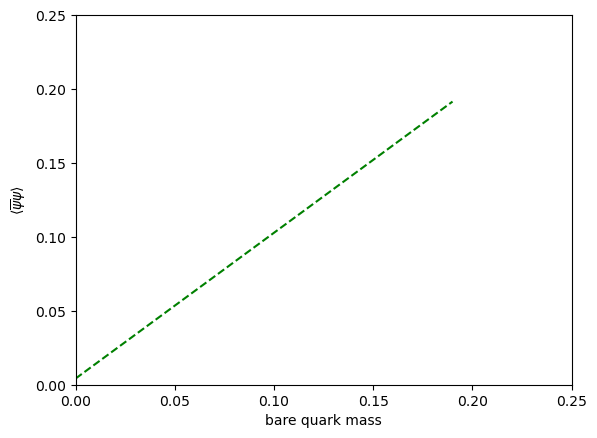

In [92]:
#modify this cell
fig1, ax1 = plt.subplots()
ax1.set_xlabel("bare quark mass")
ax1.set_ylabel(r"$\langle \overline{\psi}\psi \rangle$")
ax1.set_xlim(0,0.25)
ax1.set_ylim(0,0.25)
x = np.arange(0,0.2,0.01)

#this will draw a line to help with the extrapolation
ax1.plot(x, [chiral_condensate_beta_5p9_Ls12[0][0]
+ (chiral_condensate_beta_5p9_Ls12[2][0]
- chiral_condensate_beta_5p9_Ls12[0][0])*(xx-0.05)/0.1 for xx in x
], "g--")

#plot chiral condensate here